#### 导入数据

In [1]:
# 警告处理 
import warnings
warnings.filterwarnings('ignore')
# 在Jupyter上画图
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
# 读取CSV文件为一个DataFrame对象
df = pd.read_csv('dataset\Aquifer\Aquifer_Auser.csv')

data_info = df.info()
data_description = df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     8154 non-null   object 
 1   Rainfall_Gallicano                       5295 non-null   float64
 2   Rainfall_Pontetetto                      5295 non-null   float64
 3   Rainfall_Monte_Serra                     5289 non-null   float64
 4   Rainfall_Orentano                        5295 non-null   float64
 5   Rainfall_Borgo_a_Mozzano                 5295 non-null   float64
 6   Rainfall_Piaggione                       4930 non-null   float64
 7   Rainfall_Calavorno                       5295 non-null   float64
 8   Rainfall_Croce_Arcana                    5295 non-null   float64
 9   Rainfall_Tereglio_Coreglia_Antelminelli  5295 non-null   float64
 10  Rainfall_Fabbriche_di_Vallico            5295 no

#### 数据预处理  


##### 数据可视化
数据


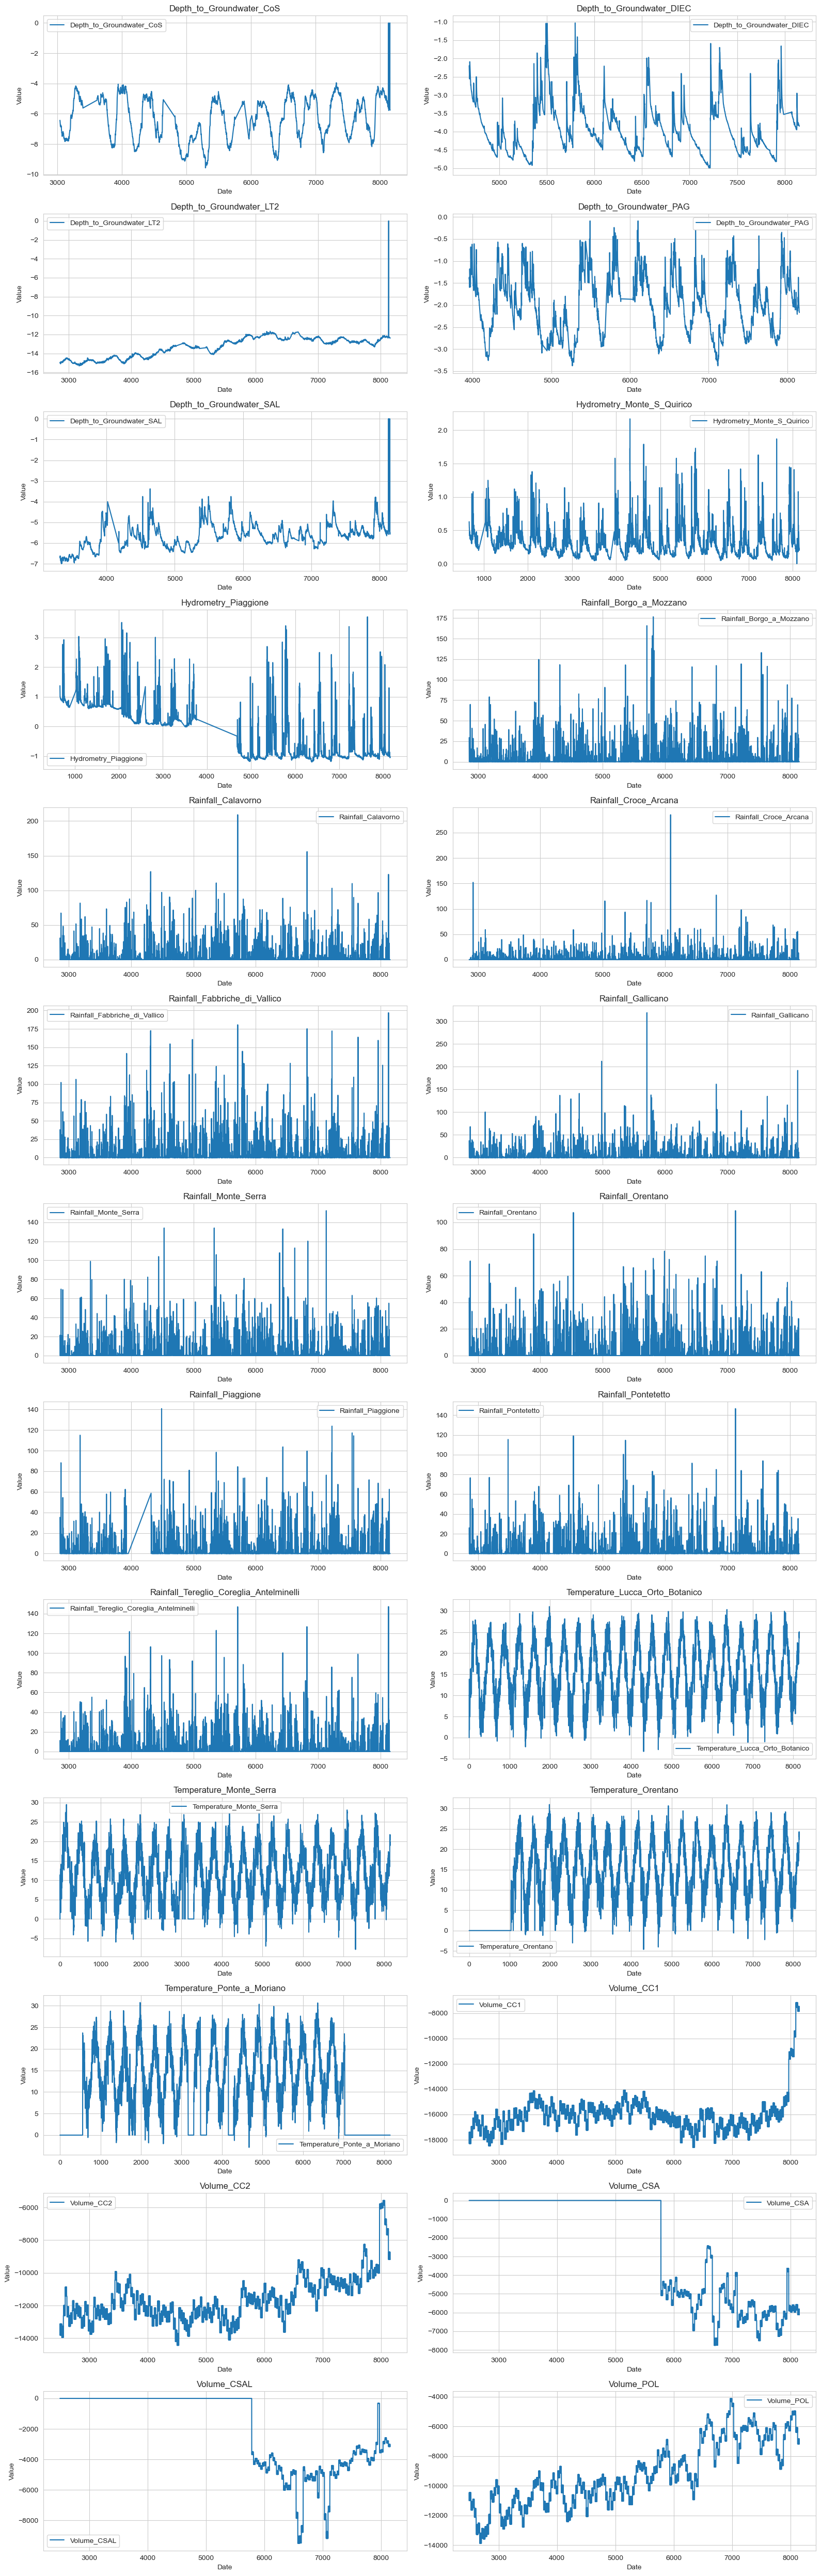

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件为一个DataFrame对象
df = pd.read_csv('dataset\Aquifer\Aquifer_Auser.csv')

# 获取除了标签列之外的所有数据列
data_columns = df.columns.difference(['Date'])
# 使用Seaborn设置样式
sns.set_style("whitegrid")

# 创建一个图形
plt.figure(figsize=(16, 50))

# 循环遍历每个数据列并绘制它们的折线图
for column in data_columns:
    plt.subplot(13, 2, data_columns.get_loc(column) + 1)
    sns.lineplot(data=df, x=df.index, y=column, label=column)
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Value')

# 调整子图的布局
plt.tight_layout()

# 显示图形
plt.show()


我们可以看到，首先需要处理的是缺失值问题  

Date                                          0
Rainfall_Gallicano                         2859
Rainfall_Pontetetto                        2859
Rainfall_Monte_Serra                       2865
Rainfall_Orentano                          2859
Rainfall_Borgo_a_Mozzano                   2859
Rainfall_Piaggione                         3224
Rainfall_Calavorno                         2859
Rainfall_Croce_Arcana                      2859
Rainfall_Tereglio_Coreglia_Antelminelli    2859
Rainfall_Fabbriche_di_Vallico              2859
Depth_to_Groundwater_LT2                   3352
Depth_to_Groundwater_SAL                   3609
Depth_to_Groundwater_PAG                   4347
Depth_to_Groundwater_CoS                   3839
Depth_to_Groundwater_DIEC                  4884
Temperature_Orentano                          0
Temperature_Monte_Serra                       0
Temperature_Ponte_a_Moriano                   0
Temperature_Lucca_Orto_Botanico               0
Volume_POL                              

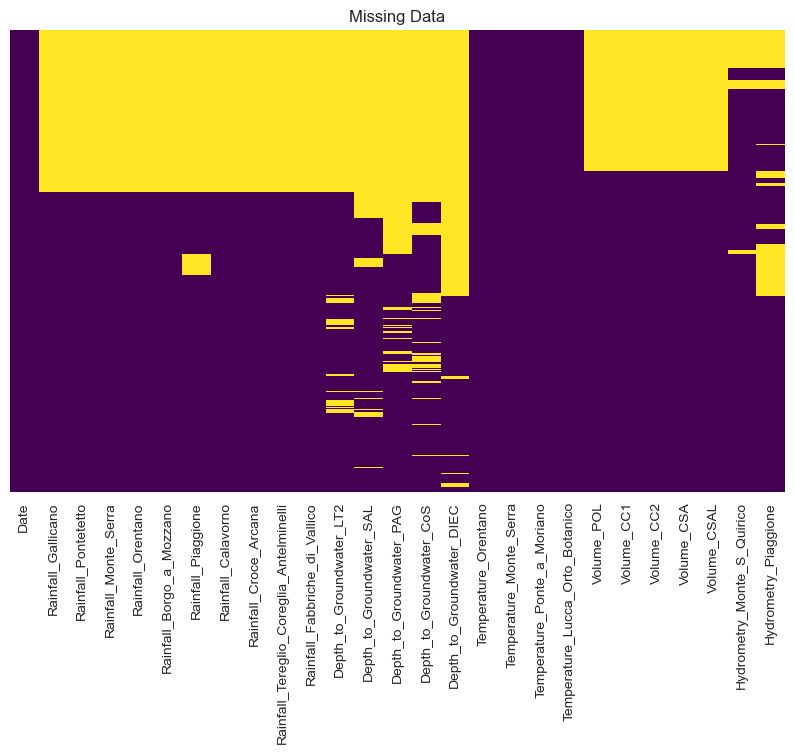

In [4]:
# 检测缺失值
missing_data = df.isnull().sum()

# 打印缺失值情况
print(missing_data)
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Data')
plt.show()


先对缺失值做基本的线性填充  将异常值处理

In [5]:
# 列名列表
columns_to_replace_zero = ['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG',
                            'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC', 'Temperature_Orentano']

# 将值为0的数据替换为NaN
df[columns_to_replace_zero] = df[columns_to_replace_zero].replace(0, float('nan'))


# 使用线性填充来填补缺失值
df = df.interpolate(method='linear')

# 查看填充后的DataFrame的缺失值情况
missing_data_filled = df.isnull().sum()

# 打印填充后的缺失值情况
print(missing_data_filled)

Date                                          0
Rainfall_Gallicano                         2859
Rainfall_Pontetetto                        2859
Rainfall_Monte_Serra                       2859
Rainfall_Orentano                          2859
Rainfall_Borgo_a_Mozzano                   2859
Rainfall_Piaggione                         2859
Rainfall_Calavorno                         2859
Rainfall_Croce_Arcana                      2859
Rainfall_Tereglio_Coreglia_Antelminelli    2859
Rainfall_Fabbriche_di_Vallico              2859
Depth_to_Groundwater_LT2                   2859
Depth_to_Groundwater_SAL                   3319
Depth_to_Groundwater_PAG                   3955
Depth_to_Groundwater_CoS                   3038
Depth_to_Groundwater_DIEC                  4686
Temperature_Orentano                       1035
Temperature_Monte_Serra                       0
Temperature_Ponte_a_Moriano                   0
Temperature_Lucca_Orto_Botanico               0
Volume_POL                              

看看具体效果  
结果发现'Volume_CSA', 'Volume_CSAL', 'Temperature_Ponte_a_Moriano'三行某些时间段的数据缺失异常

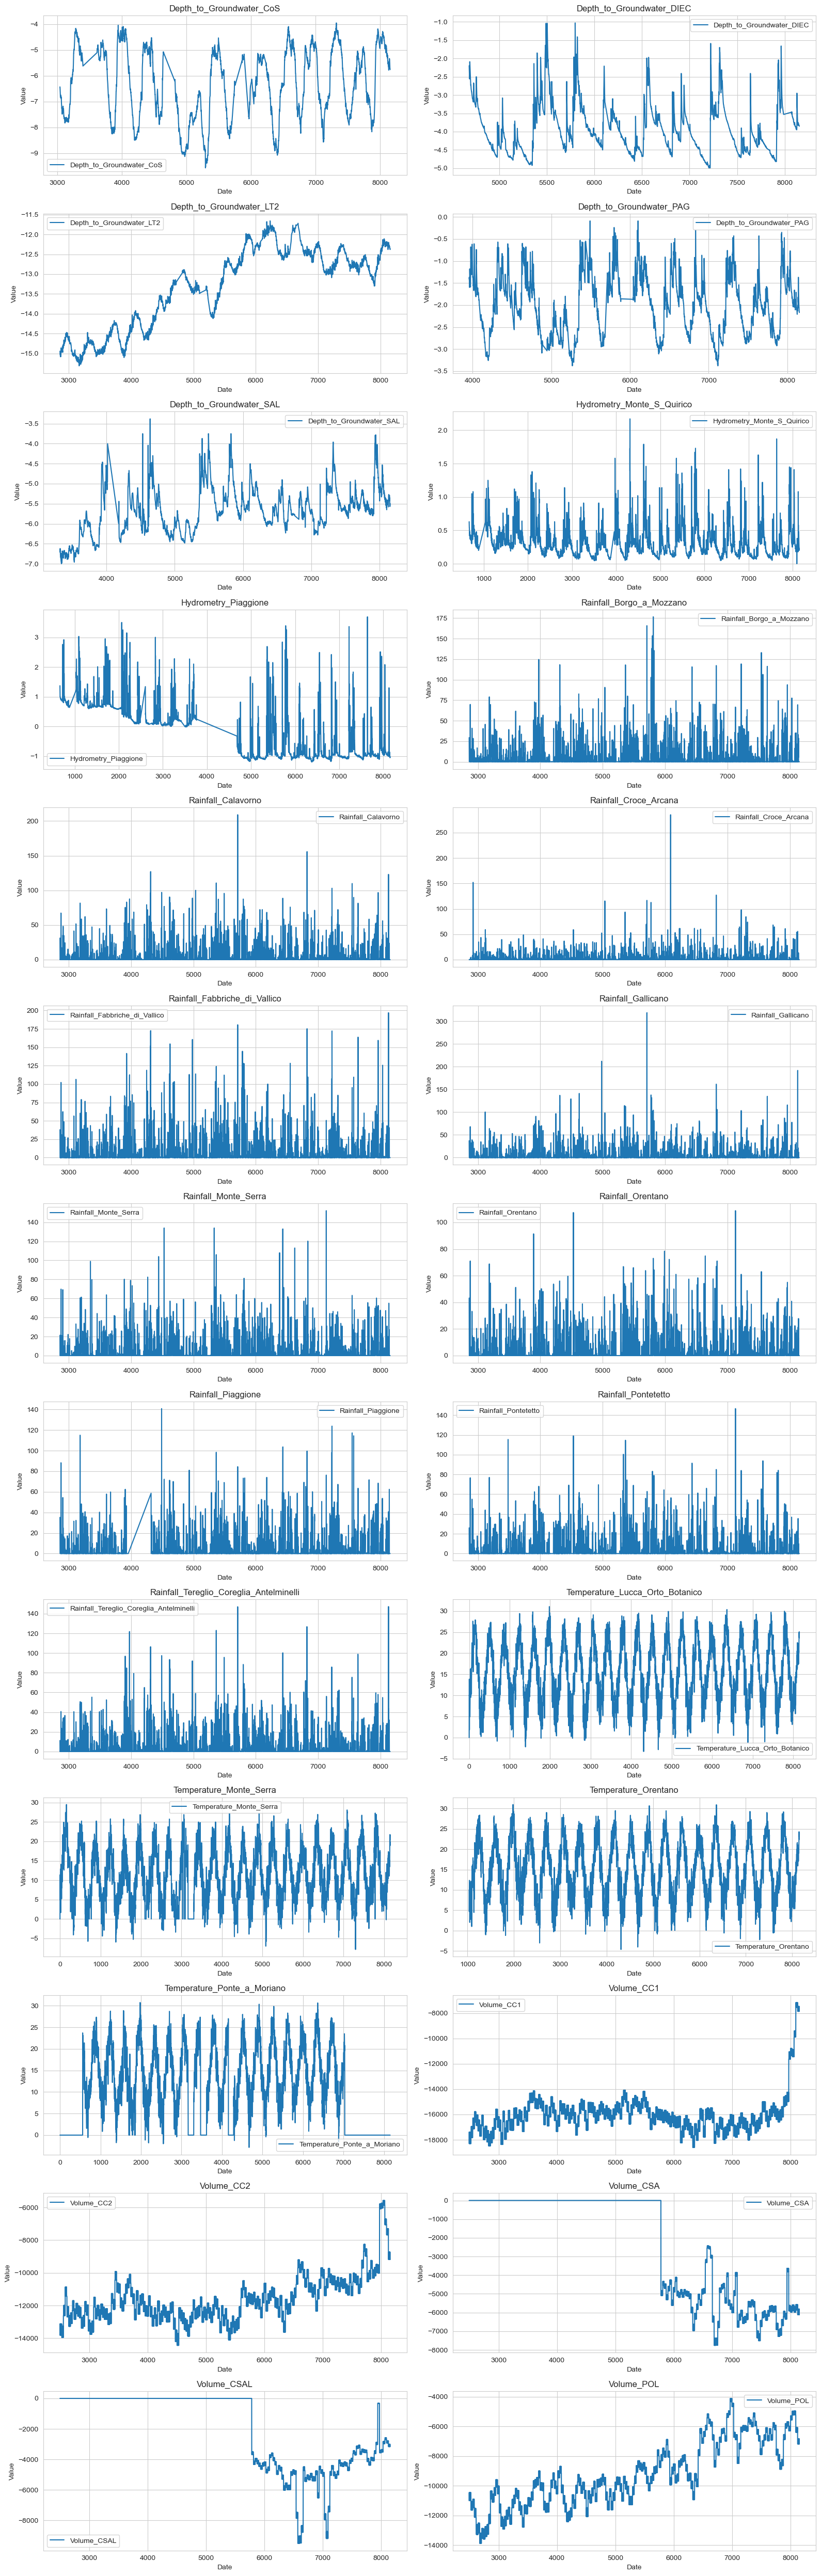

In [6]:
# 获取除了标签列之外的所有数据列
data_columns = df.columns.difference(['Date'])
# 使用Seaborn设置样式
sns.set_style("whitegrid")

# 创建一个图形
plt.figure(figsize=(16, 50))

# 循环遍历每个数据列并绘制它们的折线图
for column in data_columns:
    plt.subplot(13, 2, data_columns.get_loc(column) + 1)
    sns.lineplot(data=df, x=df.index, y=column, label=column)
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Value')

# 调整子图的布局
plt.tight_layout()

# 显示图形
plt.show()

使用KNN填充 'Volume_CSA', 'Volume_CSAL', 'Temperature_Ponte_a_Moriano' 这三列数据

In [7]:
import pandas as pd
from sklearn.impute import KNNImputer

date_col = df['Date']
df = df.drop(columns=['Date'])
columns_to_check = ['Volume_CSA', 'Volume_CSAL', 'Temperature_Ponte_a_Moriano']
for column in columns_to_check:
    df[column] = df[column].replace(0, float('nan'))

imputer = KNNImputer(n_neighbors=5)
df_filled = imputer.fit_transform(df)
df_filled = pd.DataFrame(df_filled, columns=df.columns)

df_filled['Date']=date_col
# 现在，df_filled 包含具有日期时间列的填充值。
df = df_filled


数据预处理基本完成

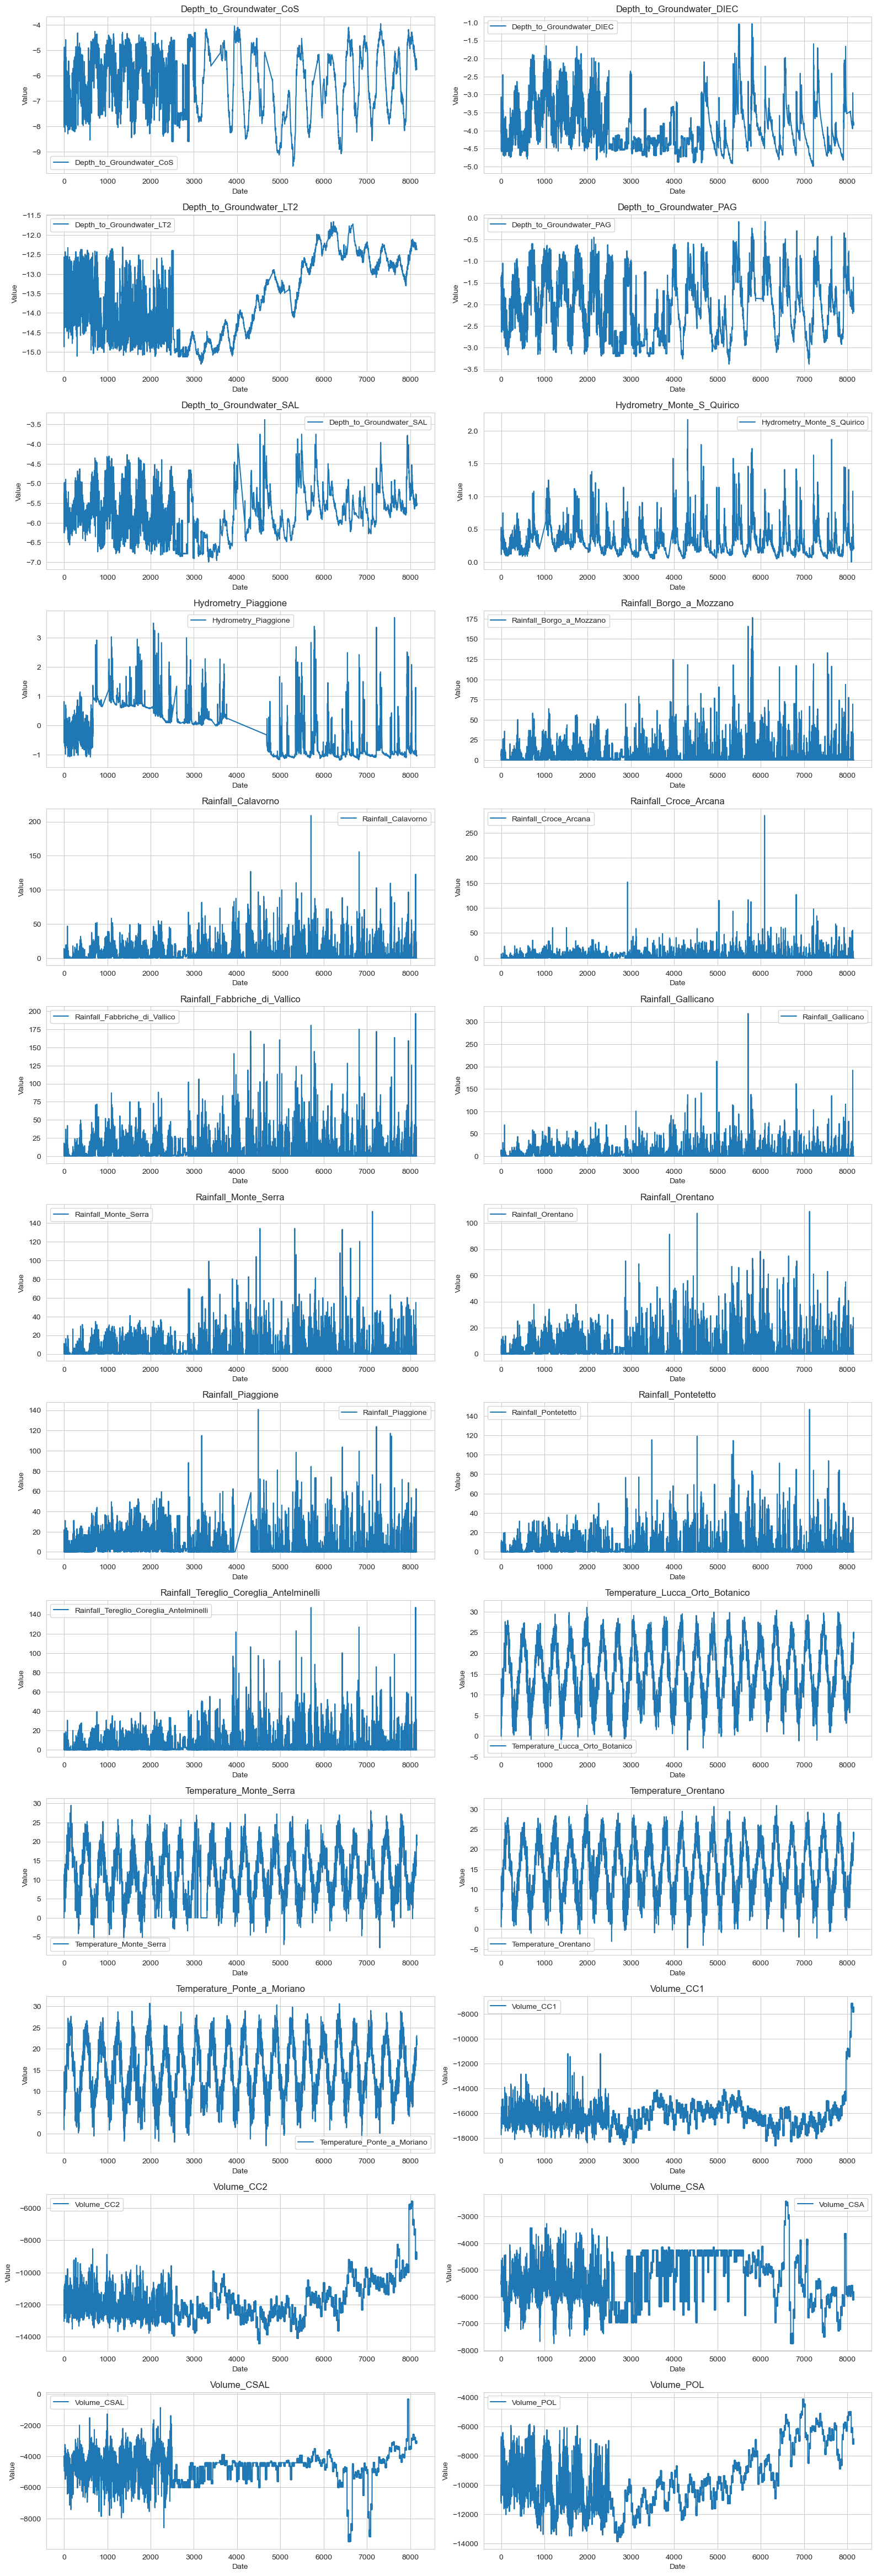

In [8]:
# 获取除了标签列之外的所有数据列
data_columns = df.columns.difference(['Date'])  # 使用填充后的 DataFrame
# 使用Seaborn设置样式
sns.set_style("whitegrid")

# 创建一个图形
plt.figure(figsize=(16, 50))

# 循环遍历每个数据列并绘制它们的折线图
for column in data_columns:
    plt.subplot(14, 2, data_columns.get_loc(column) + 1)
    sns.lineplot(data=df, x=df.index, y=column, label=column)
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Value')

# 调整子图的布局
plt.tight_layout()

# 显示图形
plt.show()

让我们看看它的箱线图

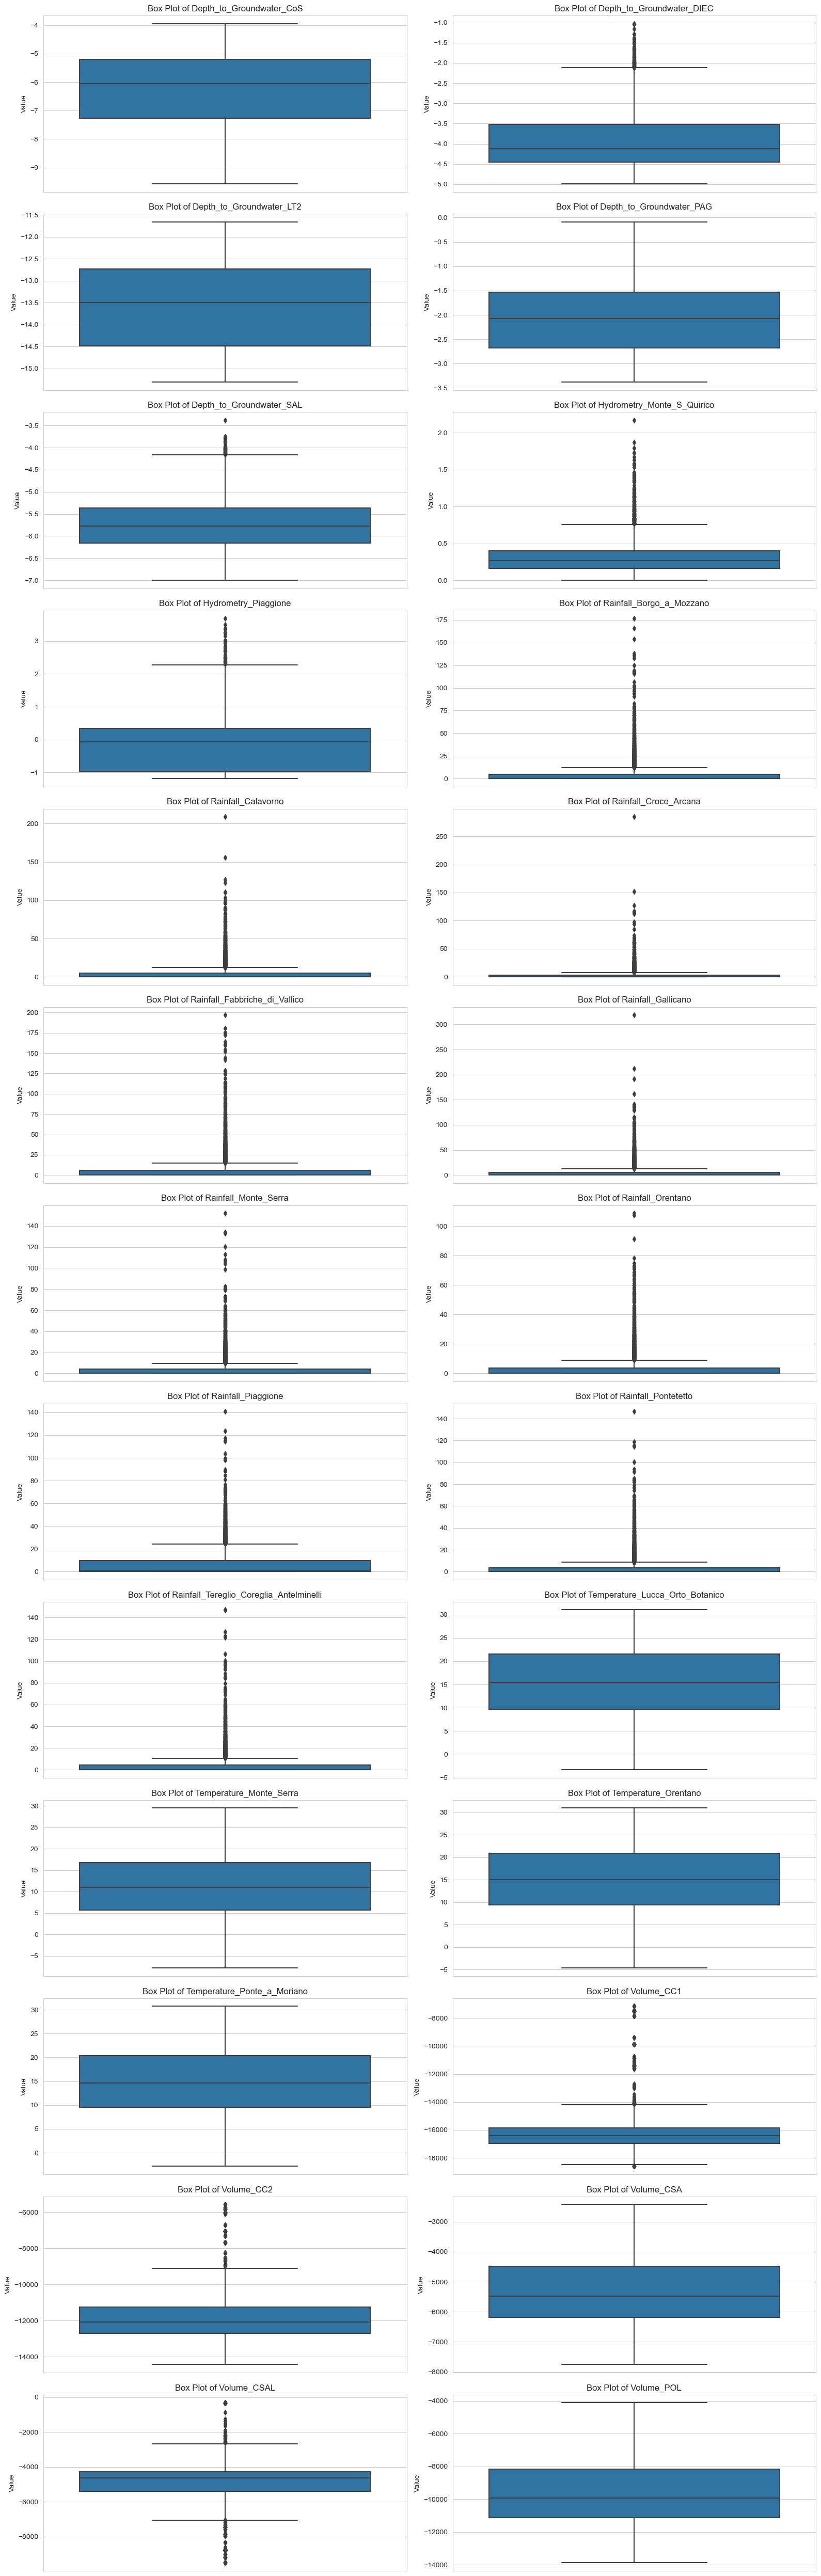

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 获取除了标签列之外的所有数据列
data_columns = df.columns.difference(['Date'])  # 使用填充后的 DataFrame

# 使用Seaborn设置样式
sns.set_style("whitegrid")

# 创建一个图形
plt.figure(figsize=(16, 50))

# 循环遍历每个数据列并绘制它们的箱线图
for i, column in enumerate(data_columns):
    plt.subplot(13, 2, i + 1)
    sns.boxplot(data=df, y=column)
    plt.title(f'Box Plot of {column}')
    plt.ylabel('Value')

# 调整子图的布局
plt.tight_layout()

# 显示图形
plt.show()


#### 模型搭建
标准化数据集

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 假设 df 包含了所有的数据

# 选择目标列
target_columns = ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']

# 选择特征列，即除了目标列以外的所有列
features = [col for col in df.columns if col not in target_columns and col !='Date']

X = df[features].values
y = df[target_columns].values

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)


划分数据集

In [14]:
import numpy as np

# 假设你的X_train和y_train的形状为 (samples, features)，其中samples是样本数，features是特征数
# 假设time_steps为7
time_steps = 7  # 时间窗口大小设置为一周的数据点数
# 定义一个函数来将数据按时间窗口大小切割成序列
def create_sequences(X, y, time_steps):
    X_sequences, y_sequences = [], []
    for i in range(len(X) - time_steps):
        X_sequences.append(X[i:i+time_steps])
        y_sequences.append(y[i+time_steps])
    return np.array(X_sequences), np.array(y_sequences)

# 调用函数来生成序列数据
X_sequences, y_sequences = create_sequences(X, y, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=0)
# 检查数据形状
print(X_train.shape)  # 应该为 (samples, time_steps, features)

# 现在你可以使用 X_train 和 y_train 来训练模型

(6517, 7, 23)


##### 搭建基本LSTM模型

In [15]:
from tensorflow.keras.layers import Bidirectional, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
# 创建双向循环神经网络模型

LSTMmodel = Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(time_steps, X_train.shape[2])))
LSTMmodel.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
LSTMmodel.add(Bidirectional(LSTM(16, activation='relu')))
LSTMmodel.add(Dense(len(target_columns)))

# 编译模型
LSTMmodel.compile(optimizer='adam', loss='mean_squared_error')


开始训练

In [16]:




# 训练模型
LSTMmodel.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2)

# 在测试集上评估模型
loss = LSTMmodel.evaluate(X_test, y_test)
lstm_predictions = LSTMmodel.predict(X_test)
print(f"Test Loss: {loss}")
# 计算MAE
mae = mean_absolute_error(y_test, lstm_predictions)
print(f"Mean Absolute Error (MAE): {mae}")



Epoch 1/300
163/163 [==============================] - 5s 10ms/step - loss: 0.3823 - val_loss: 0.2311
Epoch 2/300
163/163 [==============================] - 1s 6ms/step - loss: 0.2168 - val_loss: 0.1951
Epoch 3/300
163/163 [==============================] - 1s 6ms/step - loss: 0.1803 - val_loss: 0.1709
Epoch 4/300
163/163 [==============================] - 1s 6ms/step - loss: 0.1630 - val_loss: 0.1652
Epoch 5/300
163/163 [==============================] - 1s 6ms/step - loss: 0.1520 - val_loss: 0.1478
Epoch 6/300
163/163 [==============================] - 1s 6ms/step - loss: 0.1415 - val_loss: 0.1504
Epoch 7/300
163/163 [==============================] - 1s 6ms/step - loss: 0.1376 - val_loss: 0.1395
Epoch 8/300
163/163 [==============================] - 1s 6ms/step - loss: 0.1285 - val_loss: 0.1422
Epoch 9/300
163/163 [==============================] - 1s 6ms/step - loss: 0.1287 - val_loss: 0.1496
Epoch 10/300
163/163 [==============================] - 1s 6ms/step - loss: 0.1292 - val_l

##### 搭建线性回归模型

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Reshape data for linear regression (flatten the sequence dimension)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


# 创建线性回归模型（针对每个目标列）
models = [LinearRegression() for _ in range(y_train.shape[1])]

# 训练模型
for i, model in enumerate(models):
    model.fit(X_train_flat, y_train[:, i])

# 在测试集上进行预测
predictions = [model.predict(X_test_flat) for model in models]

# 计算每个目标列的均方误差（MSE）作为评估指标
mse_scores = [mean_squared_error(y_test[:, i], pred) for i, pred in enumerate(predictions)]

# 输出每个目标列的MSE
for i, target_column in enumerate(target_columns):
    print(f"MSE for {target_column}: {mse_scores[i]}")
total_mse = sum(mse_scores)/3
print(f"Total MSE : {total_mse}")


MSE for Depth_to_Groundwater_SAL: 0.3268064867285602
MSE for Depth_to_Groundwater_CoS: 0.3922755095462572
MSE for Depth_to_Groundwater_LT2: 0.2387454657297934
Total MSE : 0.3192758206682036


##### 搭建xgboost模型

In [18]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error

# 创建XGBoost回归模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# 将数据重新整形为适合XGBoost的形状
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 训练模型
model.fit(X_train_flat, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test_flat)

# 计算均方误差（MSE）作为评估指标
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
# 计算MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 0.14139340650649557
Mean Absolute Error (MAE): 0.2361132462511113


In [19]:
xgboost_predictions=y_pred

##### 搭建arima模型

Estimated d value: 0


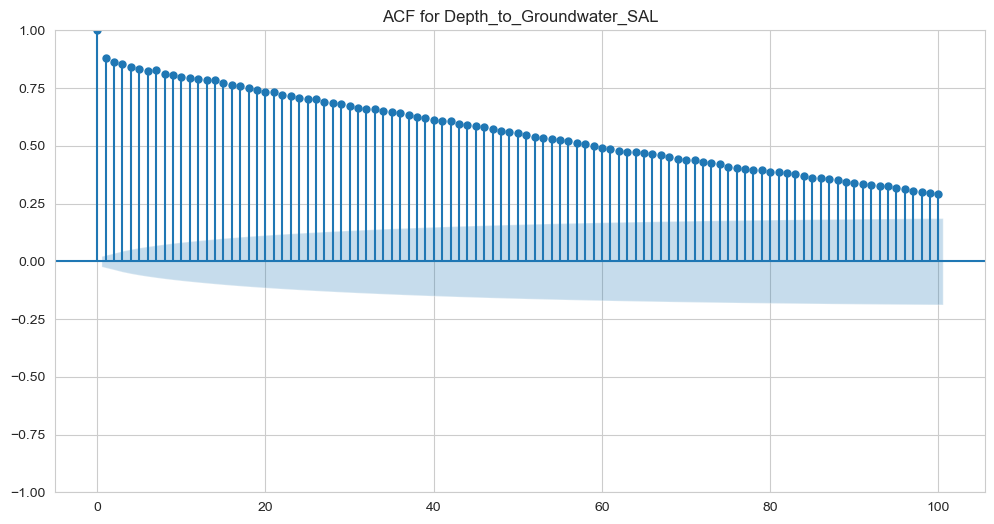

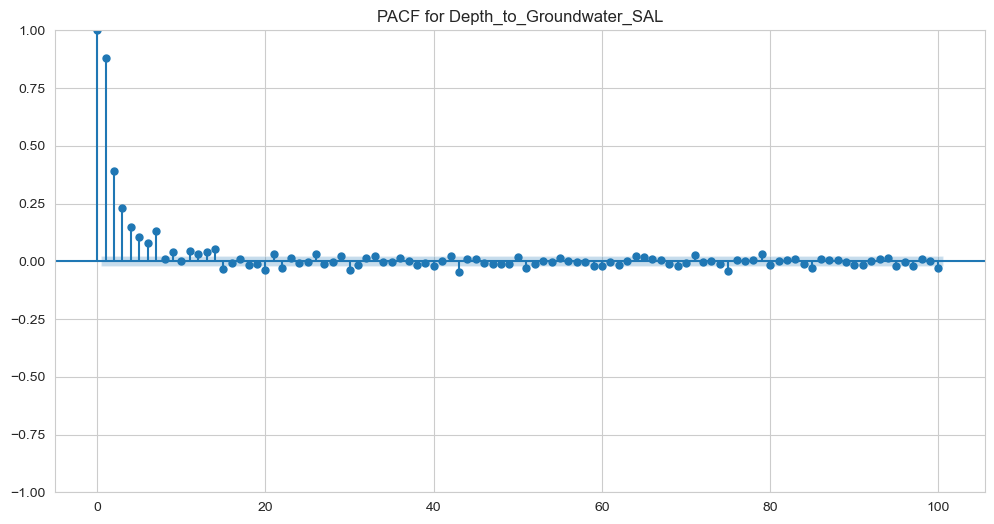

Estimated d value: 0


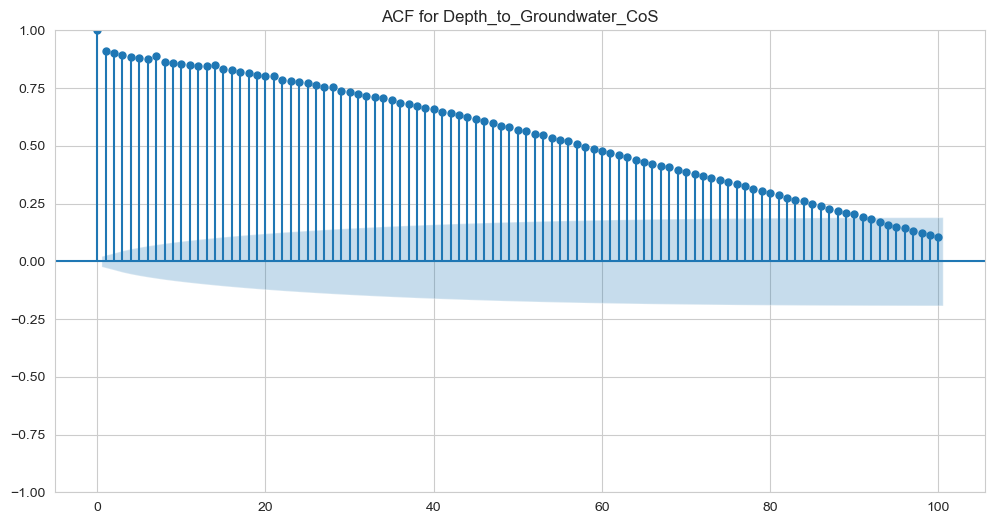

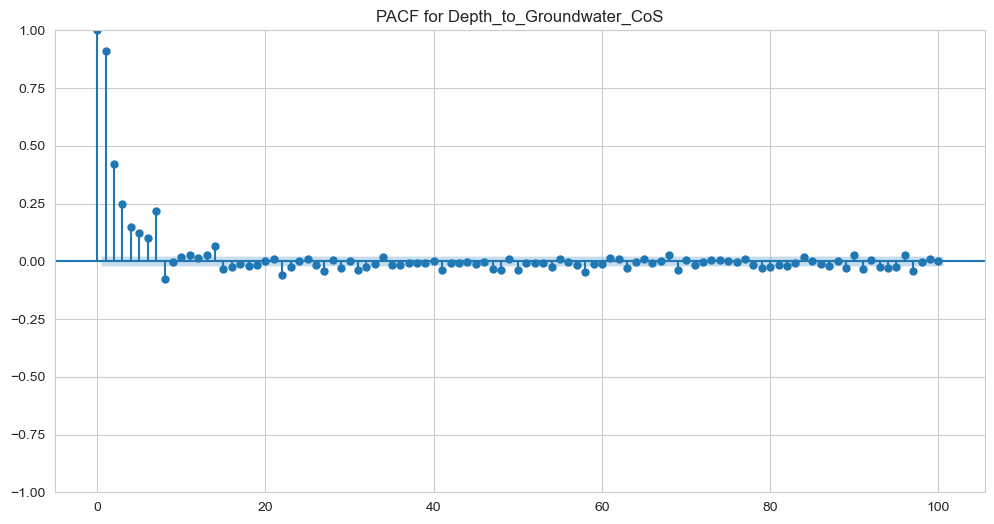

Estimated d value: 0


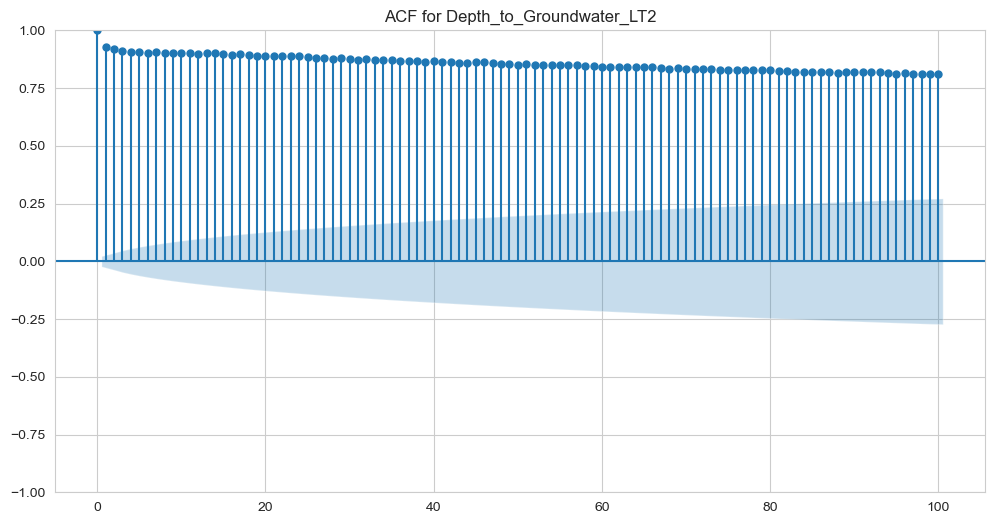

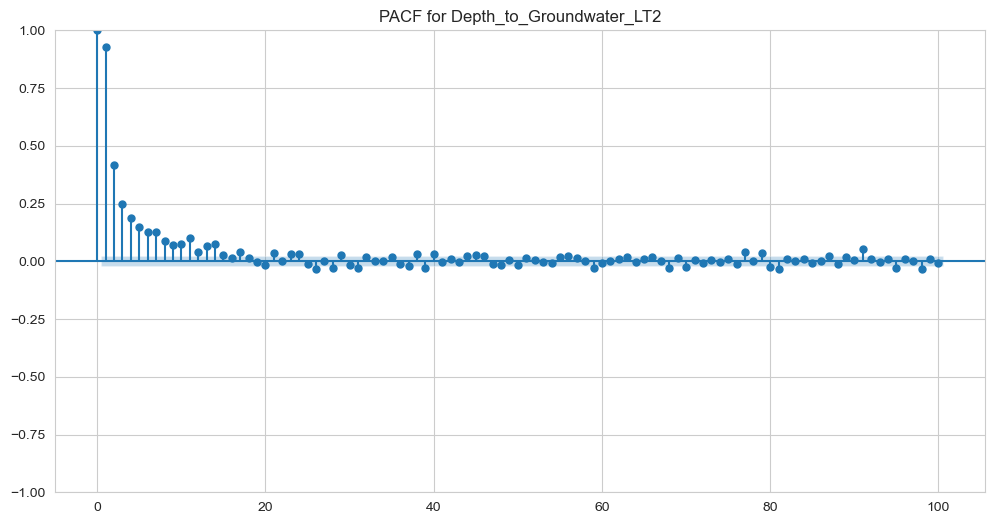

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 假设您的DataFrame已包含一个日期时间列，例如"Date"，请替换为您的实际列名
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
# 读取时间序列数据
data = df[df['Date'] < '2019-01-01']

# 迭代处理每个时间序列列
target_columns = ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']

# 定义一个函数来执行ADF检验并确定d值
def find_d_value(time_series):
    d = 0
    p_value = 1.0
    while p_value > 0.05:
        time_series_diff = time_series.diff().dropna()
        _, p_value, *_ = adfuller(time_series_diff)
        if p_value > 0.05:
            d += 1
    return d
for column_name in target_columns:
    target_column=data[target_columns][column_name]
    d = find_d_value(target_column)
    print(f"Estimated d value: {d}")
    
    # 绘制ACF图
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    plot_acf(target_column, lags=100, ax=ax)
    plt.title(f"ACF for {column_name}")
    plt.show()

    # 绘制PACF图
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    plot_pacf(target_column, lags=100, ax=ax)
    plt.title(f"PACF for {column_name}")
    plt.show()




<Figure size 1200x600 with 0 Axes>

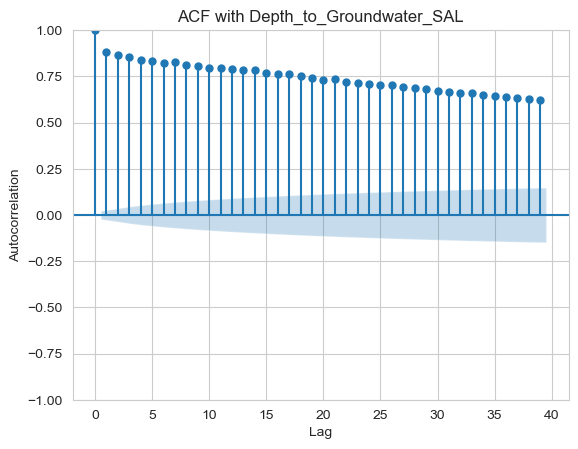

<Figure size 1200x600 with 0 Axes>

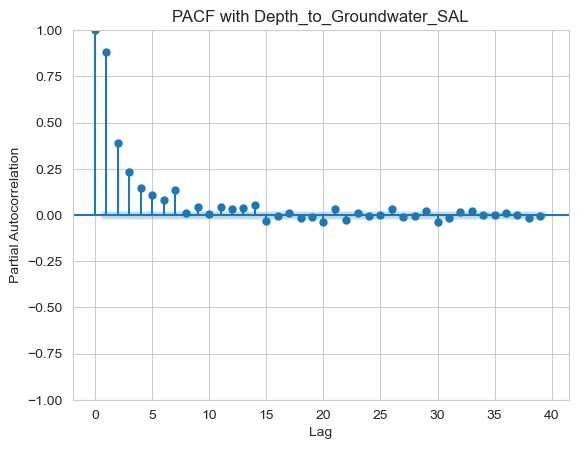

Mean Squared Error (MSE): 0.1777005550890543
Mean Absolute Error (MAE): 0.2852455958101179


In [28]:
from statsmodels.tsa.arima.model import ARIMA

# 选择一个单一的时间序列列作为目标列
train_data1 =df[df['Date'] < '2019-01-01'] 
test_data1 = df[df['Date'] >= '2019-01-01']
train_data1 = train_data1['Depth_to_Groundwater_SAL']
test_data1 = test_data1['Depth_to_Groundwater_SAL']

# 绘制ACF图
plt.figure(figsize=(12, 6))
plot_acf(train_data1, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF with Depth_to_Groundwater_SAL')
plt.show()

# 绘制PACF图
plt.figure(figsize=(12, 6))
plot_pacf(train_data1, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF with Depth_to_Groundwater_SAL')
plt.show()

# 创建ARIMA模型
model = ARIMA(train_data1, order=(1, 1, 0))

# 拟合模型
model_fit = model.fit()

# 进行预测
y_pred = model_fit.forecast(steps=len(test_data1))

# 计算均方误差（MSE）作为评估指标
mse = mean_squared_error(test_data1, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# 计算MAE
mae = mean_absolute_error(test_data1, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


<Figure size 1200x600 with 0 Axes>

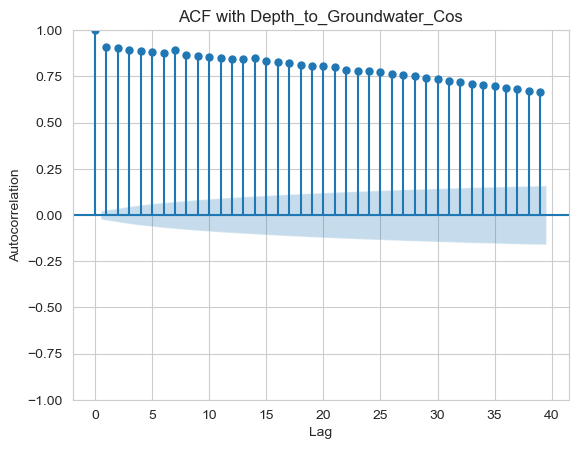

<Figure size 1200x600 with 0 Axes>

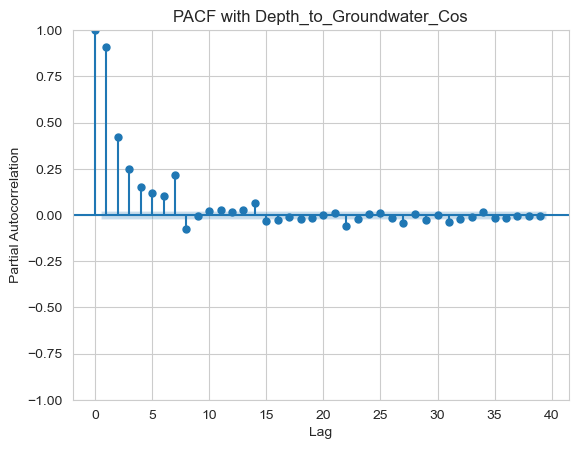

Mean Squared Error (MSE): 1.4756521284121211
Mean Absolute Error (MAE): 1.0950529285932824


In [29]:
from statsmodels.tsa.arima.model import ARIMA
# target_columns = ['Depth_to_Groundwater_SAL',  'Depth_to_Groundwater_LT2']
# 选择一个单一的时间序列列作为目标列
train_data1 =df[df['Date'] < '2019-01-01'] 
test_data1 = df[df['Date'] >= '2019-01-01']
train_data1 = train_data1['Depth_to_Groundwater_CoS']
test_data1 = test_data1['Depth_to_Groundwater_CoS']

# 绘制ACF图
plt.figure(figsize=(12, 6))
plot_acf(train_data1, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF with Depth_to_Groundwater_Cos')
plt.show()

# 绘制PACF图
plt.figure(figsize=(12, 6))
plot_pacf(train_data1, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF with Depth_to_Groundwater_Cos')
plt.show()

# 创建ARIMA模型
model = ARIMA(train_data1, order=(1, 0, 0))

# 拟合模型
model_fit = model.fit()

# 进行预测
y_pred = model_fit.forecast(steps=len(test_data1))

# 计算均方误差（MSE）作为评估指标
mse = mean_squared_error(test_data1, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# 计算MAE
mae = mean_absolute_error(test_data1, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


<Figure size 1200x600 with 0 Axes>

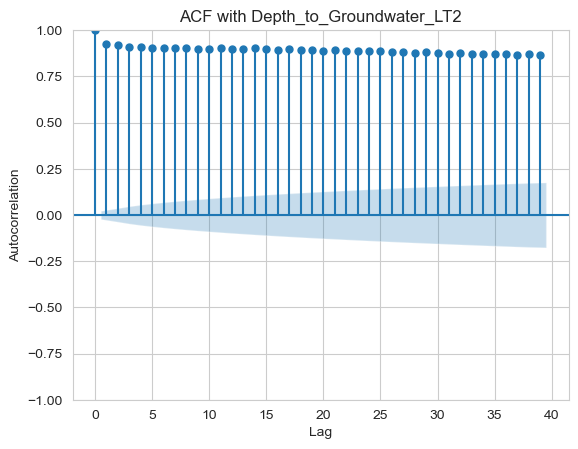

<Figure size 1200x600 with 0 Axes>

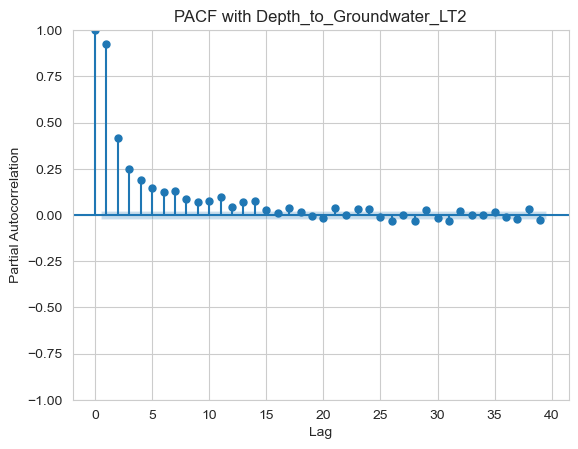

Mean Squared Error (MSE): 0.8878622579720217
Mean Absolute Error (MAE): 0.8663891612831203


In [30]:
from statsmodels.tsa.arima.model import ARIMA

# 选择一个单一的时间序列列作为目标列
train_data1 =df[df['Date'] < '2019-01-01'] 
test_data1 = df[df['Date'] >= '2019-01-01']
train_data1 = train_data1['Depth_to_Groundwater_LT2']
test_data1 = test_data1['Depth_to_Groundwater_LT2']

# 绘制ACF图
plt.figure(figsize=(12, 6))
plot_acf(train_data1, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF with Depth_to_Groundwater_LT2')
plt.show()

# 绘制PACF图
plt.figure(figsize=(12, 6))
plot_pacf(train_data1, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF with Depth_to_Groundwater_LT2')
plt.show()

# 创建ARIMA模型
model = ARIMA(train_data1, order=(3, 0, 0))

# 拟合模型
model_fit = model.fit()

# 进行预测
y_pred = model_fit.forecast(steps=len(test_data1))

# 计算均方误差（MSE）作为评估指标
mse = mean_squared_error(test_data1, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# 计算MAE
mae = mean_absolute_error(test_data1, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


对两种模型的结果画图  进行直观的比较

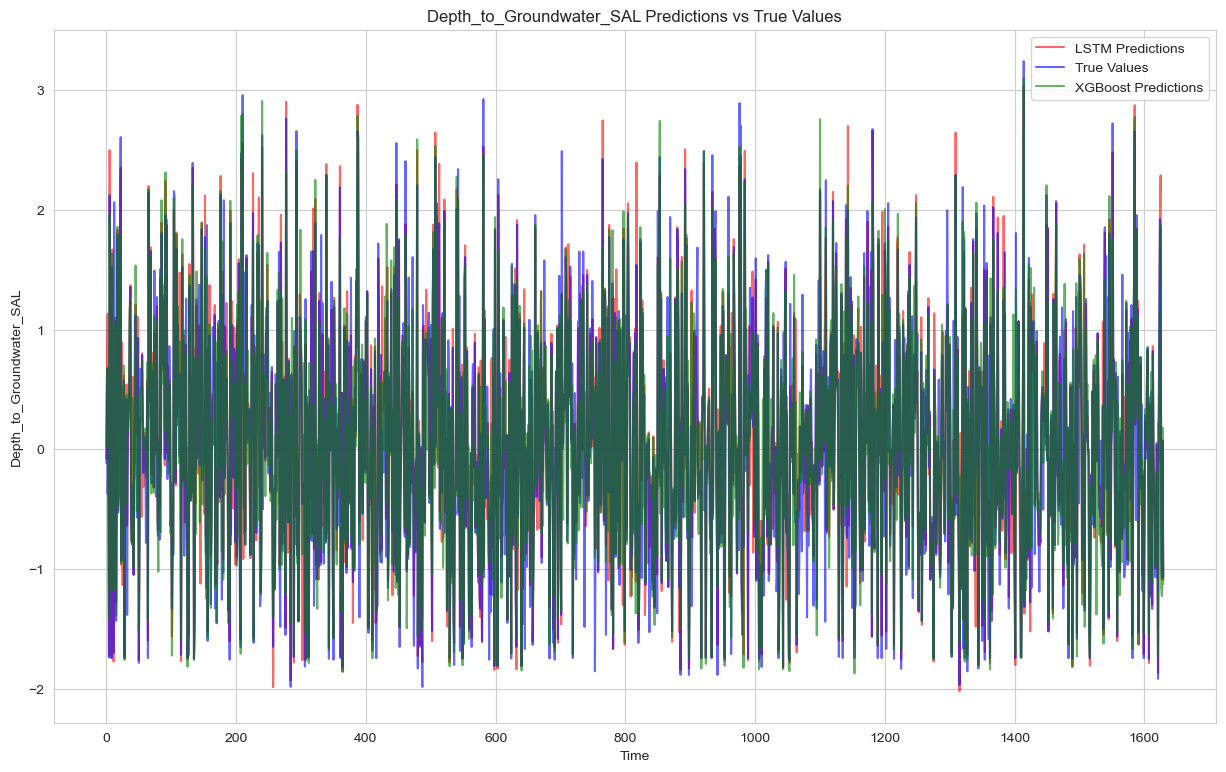

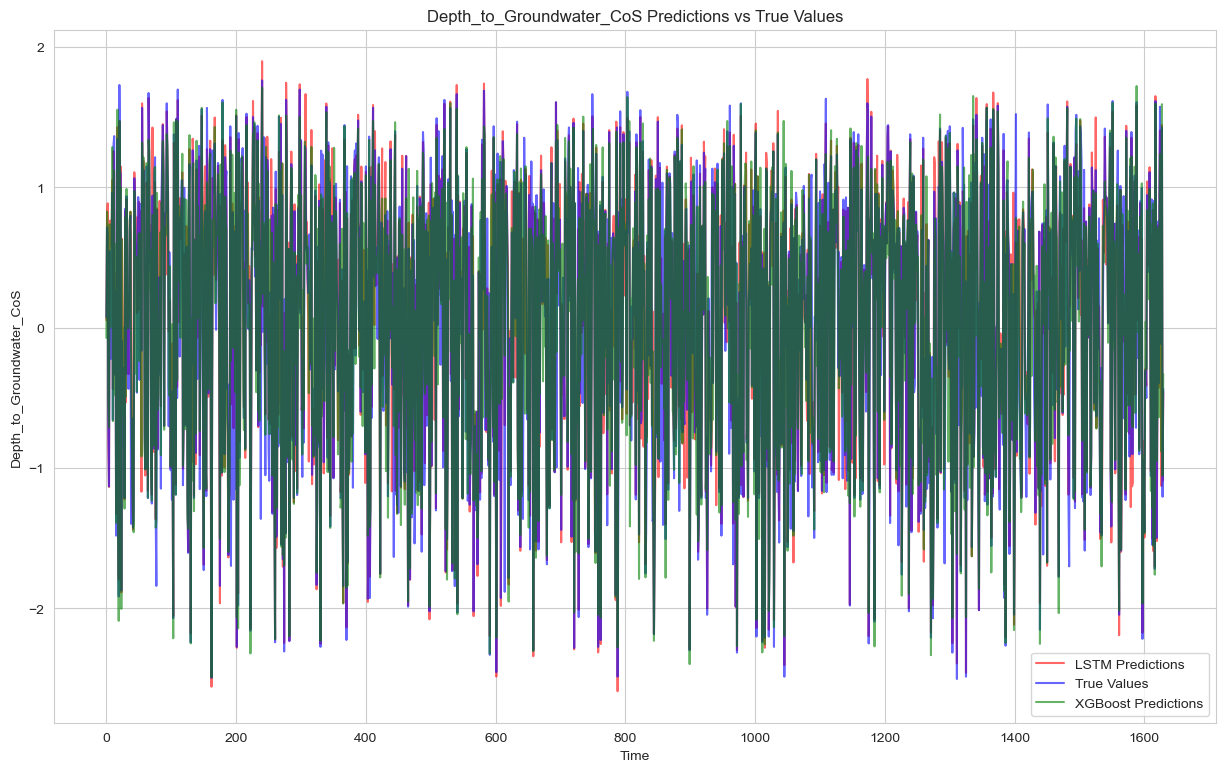

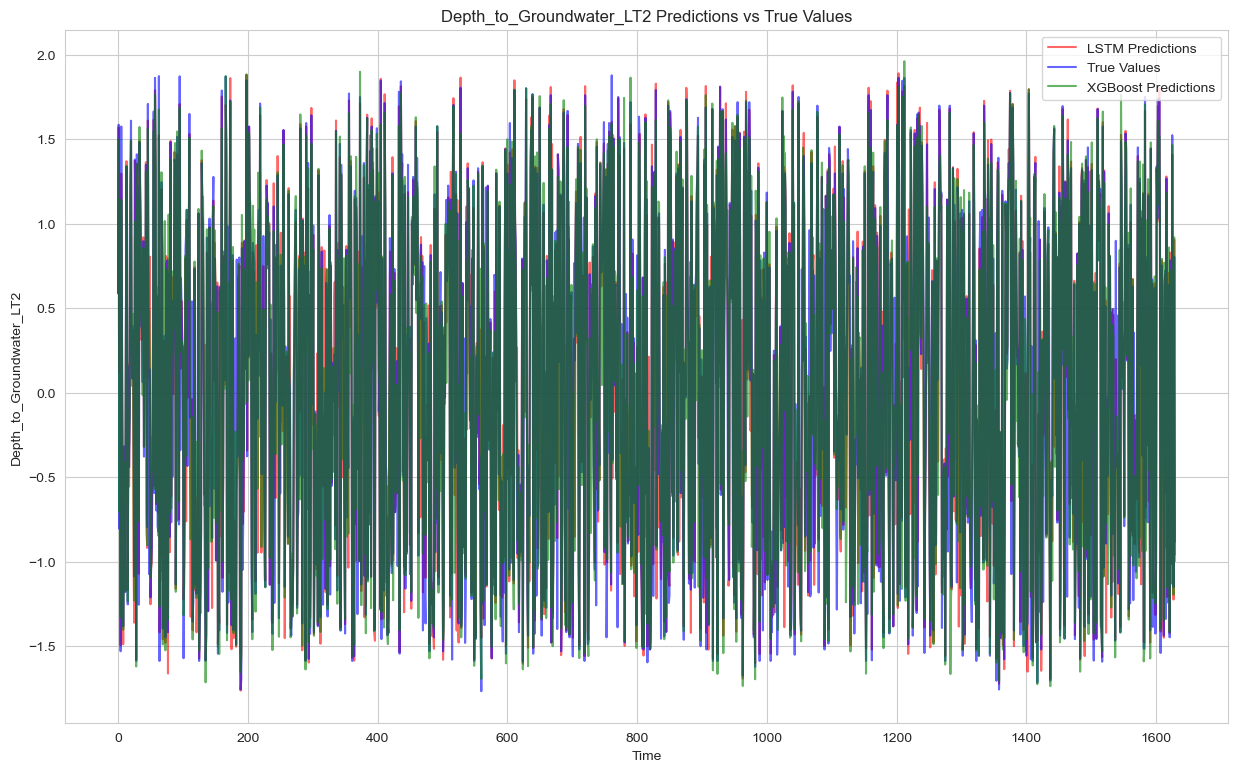

In [38]:
# 绘制每个目标列的预测值与真实值的比较图
for i, target_column in enumerate(target_columns):
    plt.figure(figsize=(15, 9))
    # 绘制LSTM模型预测值
    plt.plot(range(len(y_test)), lstm_predictions[:, i], label='LSTM Predictions', color='red', alpha=0.6)
    # 绘制真实值
    plt.plot(range(len(y_test)), y_test[:,i], label='True Values', color='blue', alpha=0.6)
    # 绘制xgboost模型预测值
    plt.plot(range(len(y_test)), xgboost_predictions[:,i], label='XGBoost Predictions', color='green', alpha=0.6)
    # 设置标题和标签
    plt.title(f'{target_column} Predictions vs True Values')
    plt.xlabel('Time')
    plt.ylabel(target_column)
    # 添加图例
    plt.legend()
    plt.show()